In [ ]:
import h3
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from utils.map_plotting import plot_hex_map
from utils.geospatial_tools import GeoSpatialTools
from utils.process_in_batch import process_parquet_in_chunks
from sklearn.impute import KNNImputer


__geo_tools = GeoSpatialTools()

# 1. Data Pre-Processing

In [ ]:
# Ruta del archivo
file_path = "files/mobility_data.parquet"

# Tamaño del chunk
batch_size = 100_000

raw_base = process_parquet_in_chunks(file_path, batch_size)

,hex_id,holidays,black_friday,valentine,mothers_day,weekend,friday,night,friday_night,device_id
0,8866d3285dfffff,3233,4785,1042,1228,28872,14390,22258,2970,2399


# 2. Feature Processing & EDA

## 2.1 Check Internal base data

In [ ]:
raw_train = pd.read_csv('files/train.csv')
raw_test = pd.read_csv('files/test.csv')

# raw_base = pd.read_csv('files/inputs/h8_summary_hours.csv')
base = raw_base.drop('Unnamed: 0', axis=1)

base = base.groupby('hex_id').agg({'total_hours': 'sum', 'unique_devices': 'sum', 'unique_days': 'sum',
                                   'work_h1': 'sum','work_h2': 'sum', 'work_h3': 'sum', 'work_h4': 'sum',
                                   'wn_h1': 'sum','wn_h2': 'sum','wn_h3': 'sum','wn_h4': 'sum'}).reset_index()
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   hex_id          742 non-null    object
 1   total_hours     742 non-null    int64 
 2   unique_devices  742 non-null    int64 
 3   unique_days     742 non-null    int64 
 4   work_h1         742 non-null    int64 
 5   work_h2         742 non-null    int64 
 6   work_h3         742 non-null    int64 
 7   work_h4         742 non-null    int64 
 8   wn_h1           742 non-null    int64 
 9   wn_h2           742 non-null    int64 
 10  wn_h3           742 non-null    int64 
 11  wn_h4           742 non-null    int64 
dtypes: int64(11), object(1)
memory usage: 69.7+ KB


In [6]:
base['in_train']=np.where(base['hex_id'].isin(raw_train['hex_id']), 1, 0)
base['in_test']=np.where(base['hex_id'].isin(raw_test['hex_id']), 1, 0)
base.groupby('resolution').agg({'in_train': 'sum', 'in_test': 'sum'})

,in_train,in_test
resolution,,
51,193,159
71,193,197


We will need to handle missing values as there are less h3_id from train & test dfs

## Deal with missing values

In [ ]:
valid_cols = ['hex_id','total_hours','unique_devices','unique_days','work_h1','work_h2','work_h3','work_h4','wn_h1','wn_h2','wn_h3','wn_h4']
base_train = raw_train.merge(base[valid_cols], how='left', on='hex_id')


In [ ]:
raw_features = base_train[['hex_id','cost_of_living','total_hours', 'work_h1',
                    'work_h2', 'work_h3', 'work_h4', 'wn_h1', 'wn_h2', 'wn_h3', 'wn_h4']].copy()
raw_features['missing'] = raw_features['total_hours'].apply(lambda x: 1 if pd.isna(x) else 0)
raw_features

,hex_id,cost_of_living,total_hours,work_h1,work_h2,work_h3,work_h4,wn_h1,wn_h2,wn_h3,wn_h4,missing
0,8866d338abfffff,0.372854,33833.0,6028.0,4981.0,6568.0,6555.0,2527.0,2069.0,2547.0,2558.0,0
1,8866d331b1fffff,0.424494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,888f2e3b4dfffff,0.414815,6087.0,1135.0,995.0,1116.0,1098.0,473.0,402.0,450.0,418.0,0
3,888f2b9ae5fffff,0.687205,10025.0,1825.0,1517.0,1927.0,1937.0,735.0,551.0,761.0,772.0,0
4,8866d32363fffff,0.482482,4893.0,916.0,676.0,929.0,929.0,426.0,300.0,366.0,351.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
505,888f2a3b0dfffff,0.602308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
506,8866d321edfffff,0.174437,7769.0,1280.0,1003.0,1601.0,1626.0,542.0,385.0,665.0,667.0,0
507,888f2b9a09fffff,0.181930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
508,8866d33127fffff,0.347440,31911.0,5780.0,5508.0,5778.0,5817.0,2285.0,2158.0,2292.0,2293.0,0


In [31]:
m = plot_hex_map(raw_features, hex_colum='hex_id', hue_variable='missing')
m

In [71]:
raw_features['hex_parent'] = raw_features['hex_id'].apply( lambda x: h3.cell_to_parent(x, res=3))
raw_features['hex_id_to_parent'] = raw_features.apply(lambda row: __geo_tools.calculate_h3_distance(row=row,
                                                                                                    hex_1='hex_id',
                                                                                                    hex_2='hex_parent'),
                                                                                                    axis=1)
raw_features.head()

,hex_id,cost_of_living,total_hours,work_h1,work_h2,work_h3,work_h4,wn_h1,wn_h2,wn_h3,wn_h4,missing,hex_parent,hex_id_to_parent
0,8866d338abfffff,0.372854,33833.0,6028.0,4981.0,6568.0,6555.0,2527.0,2069.0,2547.0,2558.0,0,8366d3fffffffff,38.601378
1,8866d331b1fffff,0.424494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,8366d3fffffffff,40.291855
2,888f2e3b4dfffff,0.414815,6087.0,1135.0,995.0,1116.0,1098.0,473.0,402.0,450.0,418.0,0,838f2efffffffff,21.659913
3,888f2b9ae5fffff,0.687205,10025.0,1825.0,1517.0,1927.0,1937.0,735.0,551.0,761.0,772.0,0,838f2bfffffffff,57.388474
4,8866d32363fffff,0.482482,4893.0,916.0,676.0,929.0,929.0,426.0,300.0,366.0,351.0,0,8366d3fffffffff,39.969198


In [72]:
from sklearn.impute import KNNImputer

columns_to_impute = ['total_hours', 'work_h1','work_h2', 'work_h3',
                     'work_h4', 'wn_h1', 'wn_h2', 'wn_h3', 'wn_h4']
complete_columns = ['hex_id_to_parent']  # Columnas completas

# Imputación por cluster
imputed_data = []

for cluster_id, group in raw_features.groupby('hex_parent'):
    imputer = KNNImputer(n_neighbors=5)
    features = group[complete_columns + columns_to_impute]
    imputed_values = imputer.fit_transform(features)
    group[complete_columns + columns_to_impute] = imputed_values
    imputed_data.append(group)

# Reconstruimos el DataFrame final con todos los clusters
df_imputed = pd.concat(imputed_data).sort_index()

df_imputed

,hex_id,cost_of_living,total_hours,work_h1,work_h2,work_h3,work_h4,wn_h1,wn_h2,wn_h3,wn_h4,missing,hex_parent,hex_id_to_parent
0,8866d338abfffff,0.372854,33833.0,6028.0,4981.0,6568.0,6555.0,2527.0,2069.0,2547.0,2558.0,0,8366d3fffffffff,38.601378
1,8866d331b1fffff,0.424494,27951.4,5163.8,4799.4,4983.4,5054.0,2041.6,1860.6,2011.2,2037.4,1,8366d3fffffffff,40.291855
2,888f2e3b4dfffff,0.414815,6087.0,1135.0,995.0,1116.0,1098.0,473.0,402.0,450.0,418.0,0,838f2efffffffff,21.659913
3,888f2b9ae5fffff,0.687205,10025.0,1825.0,1517.0,1927.0,1937.0,735.0,551.0,761.0,772.0,0,838f2bfffffffff,57.388474
4,8866d32363fffff,0.482482,4893.0,916.0,676.0,929.0,929.0,426.0,300.0,366.0,351.0,0,8366d3fffffffff,39.969198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,888f2a3b0dfffff,0.602308,12474.4,2248.6,1662.4,2388.0,2465.8,983.0,729.0,977.4,1020.2,1,838f2afffffffff,24.072153
506,8866d321edfffff,0.174437,7769.0,1280.0,1003.0,1601.0,1626.0,542.0,385.0,665.0,667.0,0,8366d3fffffffff,48.705918
507,888f2b9a09fffff,0.181930,21447.8,3939.8,3172.0,4098.8,4121.0,1609.0,1316.2,1580.8,1610.2,1,838f2bfffffffff,62.368375
508,8866d33127fffff,0.347440,31911.0,5780.0,5508.0,5778.0,5817.0,2285.0,2158.0,2292.0,2293.0,0,8366d3fffffffff,31.248662


In [76]:
df_imputed['total_hours'] = np.where(df_imputed['missing'] == 1, df_imputed['work_h1'] + df_imputed['wn_h1'] + 
                                     df_imputed['work_h2'] + df_imputed['wn_h2'] + 
                                     df_imputed['work_h3'] + df_imputed['wn_h3'] + 
                                     df_imputed['work_h4'] + df_imputed['wn_h4']
                                     , df_imputed['total_hours'])

In [77]:
df_imputed['rate_w1'] = df_imputed['work_h1'] / df_imputed['total_hours']
df_imputed['rate_w2'] = df_imputed['work_h2'] / df_imputed['total_hours']
df_imputed['rate_w3'] = df_imputed['work_h3'] / df_imputed['total_hours']
df_imputed['rate_w4'] = df_imputed['work_h4'] / df_imputed['total_hours']
df_imputed['rate_wn1'] = df_imputed['wn_h1'] / df_imputed['total_hours']
df_imputed['rate_wn2'] = df_imputed['wn_h2'] / df_imputed['total_hours']
df_imputed['rate_wn3'] = df_imputed['wn_h3'] / df_imputed['total_hours']
df_imputed['rate_wn4'] = df_imputed['wn_h4'] / df_imputed['total_hours']

df_imputed['wn_w2'] = df_imputed['rate_w2'] * df_imputed['rate_wn2']
df_imputed['wn_w4'] = df_imputed['rate_w4'] + df_imputed['rate_wn4']

In [79]:
df_imputed.loc[df_imputed['missing'] == 1]

,hex_id,cost_of_living,total_hours,work_h1,work_h2,work_h3,work_h4,wn_h1,wn_h2,wn_h3,...,rate_w1,rate_w2,rate_w3,rate_w4,rate_wn1,rate_wn2,rate_wn3,rate_wn4,wn_w2,wn_w4
1,8866d331b1fffff,0.424494,27951.4,5163.8,4799.4,4983.4,5054.0,2041.6,1860.6,2011.2,...,0.184742,0.171705,0.178288,0.180814,0.073041,0.066566,0.071953,0.072891,0.011430,0.253705
6,888f2b9a3dfffff,0.497185,31995.6,5766.8,5010.6,6137.2,6199.0,2298.4,1972.0,2285.4,...,0.180237,0.156603,0.191814,0.193745,0.071835,0.061633,0.071429,0.072704,0.009652,0.266449
9,888f2a7455fffff,1.000000,12474.4,2248.6,1662.4,2388.0,2465.8,983.0,729.0,977.4,...,0.180257,0.133265,0.191432,0.197669,0.078801,0.058440,0.078352,0.081783,0.007788,0.279452
10,8866d33195fffff,0.564939,22201.4,4027.6,3620.4,4134.2,4188.6,1596.8,1391.6,1603.6,...,0.181412,0.163071,0.186213,0.188664,0.071923,0.062681,0.072230,0.073806,0.010221,0.262470
15,888f2a3b4bfffff,0.589981,12474.4,2248.6,1662.4,2388.0,2465.8,983.0,729.0,977.4,...,0.180257,0.133265,0.191432,0.197669,0.078801,0.058440,0.078352,0.081783,0.007788,0.279452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,888f2a3761fffff,0.222351,12474.4,2248.6,1662.4,2388.0,2465.8,983.0,729.0,977.4,...,0.180257,0.133265,0.191432,0.197669,0.078801,0.058440,0.078352,0.081783,0.007788,0.279452
496,888f2e3183fffff,0.465278,27137.6,5019.0,3845.4,5268.0,5331.0,2044.4,1547.6,2031.8,...,0.184946,0.141700,0.194122,0.196443,0.075335,0.057028,0.074870,0.075556,0.008081,0.271999
501,888f2b9903fffff,0.515575,26538.8,4733.0,4048.2,5233.6,5156.6,1894.4,1607.2,1914.0,...,0.178343,0.152539,0.197206,0.194304,0.071382,0.060560,0.072121,0.073545,0.009238,0.267849
505,888f2a3b0dfffff,0.602308,12474.4,2248.6,1662.4,2388.0,2465.8,983.0,729.0,977.4,...,0.180257,0.133265,0.191432,0.197669,0.078801,0.058440,0.078352,0.081783,0.007788,0.279452


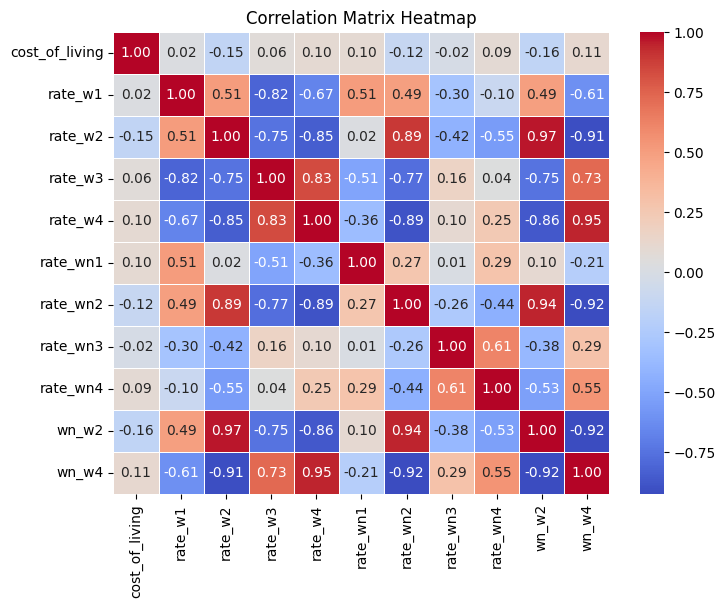

In [80]:
valid_num_cols = ['cost_of_living','rate_w1', 'rate_w2', 'rate_w3', 'rate_w4',
                    'rate_wn1', 'rate_wn2', 'rate_wn3', 'rate_wn4', 'wn_w2', 'wn_w4']

df_filter_imp = df_imputed[valid_num_cols]

# ----------------------------------------Heatmap----------------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(df_filter_imp.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Matrix Heatmap")
plt.show()

## 2.2 Add External features

### Ecuadorian important points

In [244]:
# Cargar un archivo GeoJSON
# raw_points = gpd.read_file("files\external\hotosm_ecu_points_of_interest_points_geojson.geojson")
# raw_points['hex_id'] = raw_points['geometry'].apply(lambda point: h3.latlng_to_cell(point.y, point.x, 8))
# point_cols = ['amenity', 'shop', 'hex_id', 'geometry']
# df_points = raw_points[point_cols].copy()
# df_points.to_csv('files\external\interes_points.csv', index=False)
# del raw_points




In [245]:
raw_points = pd.read_csv('files\external\interes_points.csv')
amenities = raw_points['amenity'].value_counts().reset_index()
shops = raw_points['shop'].value_counts().reset_index()

# Shops lists orignal
groceries_and_food = ["convenience", "bakery", "supermarket", "greengrocer", "butcher", "alcohol",'beverages']
lux_shop = ['jewelry', 'florist', 'mall', 'gift','confectionery','cinema','theatre']
tech_shop = ["electronics", "mobile_phone", "computer", "stationery", "variety_store"]
cars_shop = ["car_repair", "car_parts", "car", "bicycle", 'tyres']
beauty_shop = ["hairdresser", "beauty", "optician","sports","clothes", "shoes"]
house_shop = ["hardware", "department_store", "furniture", "laundry", "shoes", "kiosk"]
other_shop = ["yes", "travel_agency", "copyshop"]

# Amenities lists original
health_amenities = ["pharmacy", "dentist", "doctors", "clinic", "hospital", "veterinary"]
security_amenities = ["police", 'fire_station']
financial_amenities = ["bank", "atm"]
leisure_amenities = ["restaurant", "fast_food", "cafe", "bar", "ice_cream", "internet_cafe", "community_centre", 'nightclub','pub']
education_amenities = ["school", "college", 'university', 'kindergarten']
car_amenities = ["parking_entrance", "fuel", "parking", 'car_rental', 'car_wash']
transport_amenities = ['bus_station', 'taxi']
public_amenities = ['shelter', 'post_office', 'townhall', 'fountain', 'marketplace', 'bicycle_parking']
negative_amenities = ["waste_disposal", 'love_hotel', 'prison', 'gambling', 'stripclub', 'sanitary_dump_station', 'casino','grave_yard']
sea_amenities = ['boat_rental','scuba_diving', 'ferry_terminal', 'boat_storage', 'dive_centre']
# amenities['amenity'].unique()
# amenities[(amenities['count']<=1) & (amenities['count']>0)]

In [246]:
high_cost_hex = raw_train[raw_train['cost_of_living'] > 0.5]['hex_id'].unique()
low_cost_hex = raw_train[raw_train['cost_of_living'] <= 0.5]['hex_id'].unique()
raw_points['cost_of_living'] = np.where(raw_points['hex_id'].isin(high_cost_hex), 1,
                                        np.where(raw_points['hex_id'].isin(low_cost_hex), 2, 0))
# raw_points.head()

In [247]:
# financial_amenities = ["bank"]
health_amenities = ["doctors",'veterinary']
security_amenities = ["police", 'fire']
leisure_amenities = ["restaurant", "internet_cafe"] #["cafe", "bar",'nightclub','pub',"fast_food", "community_centre"] #
education_amenities = ["school", "college"] #['university','kindergarten']
car_amenities = ["parking_entrance", "parking", 'bus_station'] # ['car_rental', 'car_wash', "fuel"]
public_amenities = ['shelter', 'post_office', 'townhall', 'marketplace'] # ['bicycle_parking', 'fountain']
negative_amenities = ["waste_disposal"]

# shops
groceries_and_food = ["bakery", "greengrocer", "butcher", "alcohol",'beverages', "convenience", "hardware", "department_store", "laundry"] #["supermarket"]
lux_shop = ['florist', 'gift','confectionery'] # ['mall', 'jewelry', ]
tech_shop = ["electronics", "mobile_phone","beauty", "optician", "shoes"] #["stationery", "variety_store", "computer"]
cars_shop = ["car_parts", 'tyres'] # ["car", "bicycle", "car_repair"]
# beauty_shop = [] #["clothes", "sports","hairdresser"]
# house_shop = [] #["furniture", "kiosk"]
other_shop = ["yes"] #["travel_agency"]

negative_amenities = ["waste_disposal", 'love_hotel', 'prison', 'gambling', 'stripclub', 'sanitary_dump_station', 'casino', 'grave_yard']
sea_amenities = ['boat_rental','scuba_diving', 'ferry_terminal', 'boat_storage', 'dive_centre']


name_test = security_amenities

gdf_points = raw_points.loc[(raw_points['amenity'].isin(name_test)) & (raw_points['cost_of_living']>0)]
gdf_sum = gdf_points['cost_of_living'].value_counts().reset_index()
gdf_sum['total_events'] = gdf_sum['count'].sum()
gdf_sum['proportion'] = round(gdf_sum['count'] / gdf_sum['total_events'], 2)
gdf_sum.sort_values(by='cost_of_living', ascending=True)

,cost_of_living,count,total_events,proportion
1,1,29,117,0.25
0,2,88,117,0.75


### Extract list of coordinates from important points

In [243]:
raw_interes_points = gpd.read_file("files\external\hotosm_ecu_points_of_interest_points_geojson.geojson")
raw_interes_points.head()

,name,name:en,amenity,man_made,shop,tourism,opening_hours,beds,rooms,addr:full,addr:housenumber,addr:street,addr:city,source,name:es,name:qu,osm_id,osm_type,geometry
0,Centro de Salud San José de Mongas,None,doctors,None,None,None,None,None,None,None,None,None,None,None,Centro de Salud San José de Mongas,None,5035444922,nodes,POINT (-78.49595 -0.23423)
1,Banco del Pichincha,None,bank,None,None,None,None,None,None,None,None,None,None,None,Banco del Pichincha,None,5034949621,nodes,POINT (-79.88821 -2.21515)
2,GAD San Antonio de Pichincha,None,community_centre,None,None,None,None,None,None,None,None,De los Hemisferios,None,None,GAD San Antonio de Pichincha,None,5029795222,nodes,POINT (-78.44772 -0.00848)
3,BanEcuador Guasmo,None,bank,None,None,None,None,None,None,None,None,None,None,None,None,None,9297674019,nodes,POINT (-79.8915 -2.24231)
4,Stav Pollo,None,fast_food,None,None,None,None,None,None,None,None,None,None,None,None,None,10754051289,nodes,POINT (-78.50006 -0.10494)


Negative places

In [248]:
negative_for_coordinates = ["waste_disposal", 'prison']
raw_interes_points['lat_lon'] = raw_interes_points['geometry'].apply(lambda p: (p.y, p.x))

negative_points = raw_interes_points[raw_interes_points['amenity'].isin(negative_for_coordinates)]['lat_lon'].tolist()
# negative_points[:5]



Supermaxi

In [249]:
raw_supermaxi = raw_interes_points[raw_interes_points['name'].str.contains('supermaxi|megamaxi', case=False, na=False)]
supermaxi_points = raw_supermaxi['lat_lon'].tolist()
# supermaxi_points

car parts

In [250]:
cars_shop_coordinates = ["car_parts", 'tyres']
car_points = raw_interes_points[raw_interes_points['shop'].isin(cars_shop_coordinates)]['lat_lon'].tolist()

education

In [251]:
education_coordinates = ['university','kindergarten']
education_points = raw_interes_points[raw_interes_points['amenity'].isin(education_coordinates)]['lat_lon'].tolist()

Transport

In [252]:
transport_coordinates= ['bus_station', "parking", 'taxi']
transport_points = raw_interes_points[raw_interes_points['amenity'].isin(transport_coordinates)]['lat_lon'].tolist()

Security

In [253]:
security_coordinates = ['fire_station']
security_points = raw_interes_points[raw_interes_points['amenity'].isin(security_coordinates)]['lat_lon'].tolist()
len(security_points)

202

### Calculate volume of important points per hex_id

In [254]:
# Shops
raw_points['groseries_shop'] = np.where(raw_points['shop'].isin(groceries_and_food), 1, 0)
raw_points['lux_shop'] = np.where(raw_points['shop'].isin(lux_shop), 1, 0)
raw_points['tech_shop'] = np.where(raw_points['shop'].isin(tech_shop), 1, 0)
raw_points['car_shop'] = np.where(raw_points['shop'].isin(cars_shop), 1, 0)
# raw_points['beauty_shop'] = np.where(raw_points['shop'].isin(beauty_shop), 1, 0)
# raw_points['house_shop'] =  np.where(raw_points['shop'].isin(house_shop), 1, 0)
raw_points['others'] = np.where(raw_points['shop'].isin(other_shop), 1, 0)

# Amenities
raw_points['health'] = np.where(raw_points['amenity'].isin(health_amenities), 1, 0)
raw_points['security'] = np.where(raw_points['amenity'].isin(security_amenities), 1, 0)
raw_points['financial'] = np.where(raw_points['amenity'].isin(financial_amenities), 1, 0)
raw_points['leisure'] = np.where(raw_points['amenity'].isin(leisure_amenities), 1, 0)
raw_points['education'] = np.where(raw_points['amenity'].isin(education_amenities), 1, 0)
raw_points['cars'] = np.where(raw_points['amenity'].isin(car_amenities), 1, 0)
# raw_points['transport'] = np.where(raw_points['amenity'].isin(transport_amenities), 1, 0)
# raw_points['public'] = np.where(raw_points['amenity'].isin(public_amenities), 1, 0)
raw_points['negative'] = np.where(raw_points['amenity'].isin(negative_amenities), 1, 0)
raw_points['sea'] = np.where(raw_points['amenity'].isin(sea_amenities), 1, 0)

raw_points.head()

,amenity,shop,hex_id,cost_of_living,groseries_shop,lux_shop,tech_shop,car_shop,others,health,security,financial,leisure,education,cars,negative,sea
0,doctors,NaN,8866d338b9fffff,2,0,0,0,0,0,1,0,0,0,0,0,0,0
1,bank,NaN,888f2b98adfffff,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,community_centre,NaN,8866d3069dfffff,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,bank,NaN,888f2b8a45fffff,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,fast_food,NaN,8866d33a55fffff,2,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
operations = {
    'groseries_shop': 'sum',
    'lux_shop': 'sum',
    'tech_shop': 'sum',
    'car_shop': 'sum',
    'others': 'sum',
    'health': 'sum',
    'security': 'sum',
    'financial': 'sum',
    'leisure': 'sum',
    'education': 'sum',
    'cars': 'sum',
    'negative': 'sum',
    'sea': 'sum'
}

df_points = raw_points.groupby('hex_id').agg(operations).reset_index()
df_train_points = raw_train.merge(df_points, how='left', on='hex_id')


### lon-lat distance to places

In [256]:
raw_capitals = pd.read_csv('files/external/lon-lat-capitales.csv')
raw_ports = pd.read_csv('files/external/lon-lat-puertos.csv')

# Create a list of coordinates
capital_coor_list = []
for _, row in raw_capitals.iterrows():
    coordinates = (row['Latitud'], row['Longitud'])
    capital_coor_list.append(coordinates)


port_coor_list = []
for _, row in raw_ports.iterrows():
    coordinates = (row['Latitud'], row['Longitud'])
    port_coor_list.append(coordinates)

In [75]:
__geo_tools = GeoSpatialTools()
df_train_points['dis_to_capital'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=capital_coor_list))
df_train_points['dis_to_port'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=port_coor_list))
df_train_points['dis_to_negative'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=negative_points))
df_train_points['dis_to_supermaxi'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=supermaxi_points))
df_train_points['dis_car_shop'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=car_points))
df_train_points['dis_to_education'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=education_points))
df_train_points['dis_security'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=security_points))
df_train_points['dis_transport'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=transport_points))

In [76]:
costa = ['838f0dfffffffff','838f28fffffffff','838f2afffffffff', '838f2bfffffffff', '838f2cfffffffff','838f2efffffffff']
sierra = ['8366d1fffffffff', '8366d3fffffffff', '838f29fffffffff','838f2dfffffffff', '838f72fffffffff','838f76fffffffff']
oriente = ['8366dafffffffff']

df_train_points['h_3'] = df_train_points['hex_id'].apply( lambda x: h3.cell_to_parent(x, res=3))
df_train_points['costa'] = np.where(df_train_points['h_3'].isin(costa), 1, 0)
df_train_points['sierra'] = np.where(df_train_points['h_3'].isin(sierra), 1, 0)
df_train_points['oriente'] = np.where(df_train_points['h_3'].isin(oriente), 1, 0)
# df_train_points

In [78]:
df_train_points = df_train_points.fillna(0)
df_train_points.to_csv('files/external/df_train_points.csv', index=False)

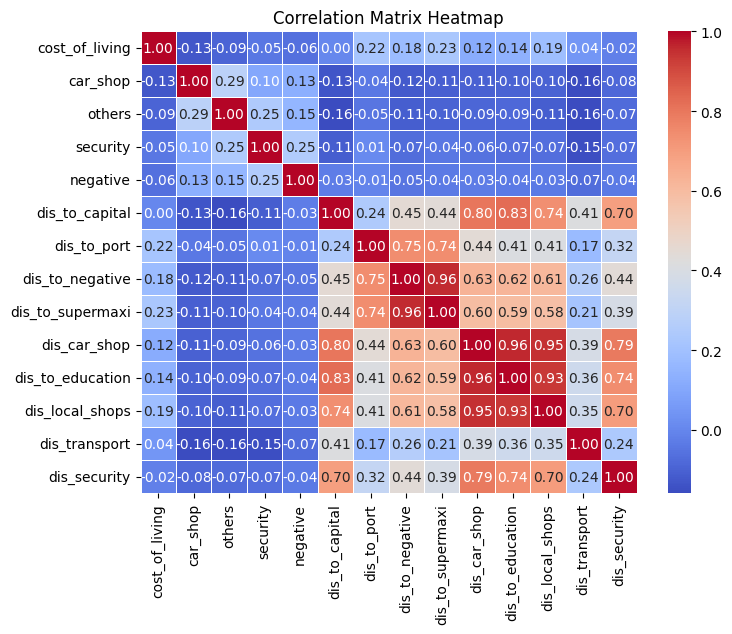

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


valid_num_cols = ['cost_of_living', 'car_shop', 'others', 'security','negative',
       'dis_to_capital', 'dis_to_port','dis_to_negative',
       'dis_to_supermaxi', 'dis_car_shop',
       'dis_to_education', 'dis_local_shops', 'dis_transport', 'dis_security']

    # 'others', 'negative', 'car_shop', 'security', 
    # 'dis_to_capital','dis_to_port', 'dis_to_negative', 'dis_to_supermaxi',
    # 'dis_car_shop', 'dis_to_education',
    # 'costa', 'sierra', 'oriente',

df_filter = df_train_points[valid_num_cols]
# df_filter  = df_filter[(df_filter['cost_of_living']>0) & (df_filter['null_points']==0)]

# ----------------------------------------Heatmap----------------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(df_filter.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Matrix Heatmap")
plt.show()


# -----------------------------------------Pair plot -------------------------------------------
# # variables summary
# cols = df_train_points.columns.tolist()
# sns.set()
# sns.pairplot(df_train_points[cols], size = 2.5)
# plt.show()

# Deal With Missing values

In [162]:
df_train_points = pd.read_csv('files/external/df_train_points.csv')
df_train_points

,hex_id,cost_of_living,groseries_shop,lux_shop,tech_shop,car_shop,others,health,security,financial,...,dis_to_negative,dis_to_supermaxi,dis_car_shop,dis_to_education,dis_security,dis_transport,h_3,costa,sierra,oriente
0,8866d338abfffff,0.372854,30.0,5.0,14.0,0.0,103.0,3.0,3.0,5.0,...,0.21,2.96,1.23,2.22,0.20,0.14,8366d3fffffffff,0,1,0
1,8866d331b1fffff,0.424494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.47,3.30,3.11,2.21,6.18,1.27,8366d3fffffffff,0,1,0
2,888f2e3b4dfffff,0.414815,24.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,5.31,26.10,4.15,5.29,2.39,5.73,838f2efffffffff,1,0,0
3,888f2b9ae5fffff,0.687205,2.0,0.0,0.0,0.0,8.0,0.0,0.0,5.0,...,6.04,3.50,2.34,3.02,2.76,0.31,838f2bfffffffff,1,0,0
4,8866d32363fffff,0.482482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.95,1.81,2.17,3.73,2.43,1.19,8366d3fffffffff,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,888f2a3b0dfffff,0.602308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,89.55,92.63,13.45,11.91,7.71,1.40,838f2afffffffff,1,0,0
506,8866d321edfffff,0.174437,7.0,0.0,3.0,0.0,4.0,1.0,0.0,0.0,...,3.01,0.64,0.61,2.15,1.51,0.65,8366d3fffffffff,0,1,0
507,888f2b9a09fffff,0.181930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.13,2.60,4.57,4.94,4.32,2.97,838f2bfffffffff,1,0,0
508,8866d33127fffff,0.347440,7.0,0.0,1.0,2.0,7.0,0.0,0.0,0.0,...,2.11,1.29,0.23,0.68,2.11,0.74,8366d3fffffffff,0,1,0


In [326]:
valid_base_cols = ['hex_id','total_hours','work_h1','work_h2','work_h3','work_h4','wn_h1','wn_h2','wn_h3','wn_h4']
valid_points_cols = ['hex_id','cost_of_living', 'dis_to_port','dis_to_negative', 'dis_to_supermaxi', 'dis_to_education','costa',
                     'dis_to_capital' , 'negative']

base_train = df_train_points[valid_points_cols].merge(base[valid_base_cols], how='left', on='hex_id')

raw_features = base_train[['hex_id','cost_of_living','total_hours', 'work_h1',
                    'work_h2', 'work_h3', 'work_h4', 'wn_h1', 'wn_h2', 'wn_h3', 'wn_h4',
                    'dis_to_port','dis_to_negative', 'dis_to_supermaxi', 'dis_to_education', 'costa',
                    'dis_to_capital', 'negative']].copy()
raw_features['missing'] = raw_features['total_hours'].apply(lambda x: 1 if pd.isna(x) else 0)
raw_features['hex_parent'] = raw_features['hex_id'].apply( lambda x: h3.cell_to_parent(x, res=3))
raw_features['hex_id_to_parent'] = raw_features.apply(lambda row: __geo_tools.calculate_h3_distance(row=row,
                                                                                                    hex_1='hex_id',
                                                                                                    hex_2='hex_parent'),
                                                                                                    axis=1)

columns_to_impute = ['total_hours', 'work_h1','work_h2', 'work_h3',
                     'work_h4', 'wn_h1', 'wn_h2', 'wn_h3', 'wn_h4']
complete_columns = ['hex_id_to_parent']  # Columnas completas

# Imputación por cluster
imputed_data = []

for cluster_id, group in raw_features.groupby('hex_parent'):
    imputer = KNNImputer(n_neighbors=5)
    features = group[complete_columns + columns_to_impute]
    imputed_values = imputer.fit_transform(features)
    group[complete_columns + columns_to_impute] = imputed_values
    imputed_data.append(group)

# Reconstruimos el DataFrame final con todos los clusters
df_imputed = pd.concat(imputed_data).sort_index()

df_imputed

,hex_id,cost_of_living,total_hours,work_h1,work_h2,work_h3,work_h4,wn_h1,wn_h2,wn_h3,...,dis_to_port,dis_to_negative,dis_to_supermaxi,dis_to_education,costa,dis_to_capital,negative,missing,hex_parent,hex_id_to_parent
0,8866d338abfffff,0.372854,33833.0,6028.0,4981.0,6568.0,6555.0,2527.0,2069.0,2547.0,...,20.38,0.21,2.96,2.22,0,1.35,5.0,0,8366d3fffffffff,38.601378
1,8866d331b1fffff,0.424494,27951.4,5163.8,4799.4,4983.4,5054.0,2041.6,1860.6,2011.2,...,8.51,3.47,3.30,2.21,0,13.42,0.0,1,8366d3fffffffff,40.291855
2,888f2e3b4dfffff,0.414815,6087.0,1135.0,995.0,1116.0,1098.0,473.0,402.0,450.0,...,4.77,5.31,26.10,5.29,1,27.25,0.0,0,838f2efffffffff,21.659913
3,888f2b9ae5fffff,0.687205,10025.0,1825.0,1517.0,1927.0,1937.0,735.0,551.0,761.0,...,2.86,6.04,3.50,3.02,1,6.02,0.0,0,838f2bfffffffff,57.388474
4,8866d32363fffff,0.482482,4893.0,916.0,676.0,929.0,929.0,426.0,300.0,366.0,...,13.57,2.95,1.81,3.73,0,8.45,0.0,0,8366d3fffffffff,39.969198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,888f2a3b0dfffff,0.602308,12474.4,2248.6,1662.4,2388.0,2465.8,983.0,729.0,977.4,...,103.99,89.55,92.63,11.91,1,7.84,0.0,1,838f2afffffffff,24.072153
506,8866d321edfffff,0.174437,7769.0,1280.0,1003.0,1601.0,1626.0,542.0,385.0,665.0,...,21.47,3.01,0.64,2.15,0,10.95,0.0,0,8366d3fffffffff,48.705918
507,888f2b9a09fffff,0.181930,21447.8,3939.8,3172.0,4098.8,4121.0,1609.0,1316.2,1580.8,...,7.10,9.13,2.60,4.94,1,10.69,0.0,1,838f2bfffffffff,62.368375
508,8866d33127fffff,0.347440,31911.0,5780.0,5508.0,5778.0,5817.0,2285.0,2158.0,2292.0,...,12.97,2.11,1.29,0.68,0,13.11,0.0,0,8366d3fffffffff,31.248662


In [327]:
df_imputed['total_hours'] = np.where(df_imputed['missing'] == 1, df_imputed['work_h1'] + df_imputed['wn_h1'] + 
                                     df_imputed['work_h2'] + df_imputed['wn_h2'] + 
                                     df_imputed['work_h3'] + df_imputed['wn_h3'] + 
                                     df_imputed['work_h4'] + df_imputed['wn_h4']
                                     , df_imputed['total_hours'])
df_imputed['rate_w1'] = df_imputed['work_h1'] / df_imputed['total_hours']
df_imputed['rate_w2'] = df_imputed['work_h2'] / df_imputed['total_hours']
df_imputed['rate_w3'] = df_imputed['work_h3'] / df_imputed['total_hours']
df_imputed['rate_w4'] = df_imputed['work_h4'] / df_imputed['total_hours']
df_imputed['rate_wn1'] = df_imputed['wn_h1'] / df_imputed['total_hours']
df_imputed['rate_wn2'] = df_imputed['wn_h2'] / df_imputed['total_hours']
df_imputed['rate_wn3'] = df_imputed['wn_h3'] / df_imputed['total_hours']
df_imputed['rate_wn4'] = df_imputed['wn_h4'] / df_imputed['total_hours']

df_imputed['wn_w2'] = df_imputed['rate_w2'] * df_imputed['rate_wn2']
df_imputed['wn_w4'] = df_imputed['rate_w4'] + df_imputed['rate_wn4']

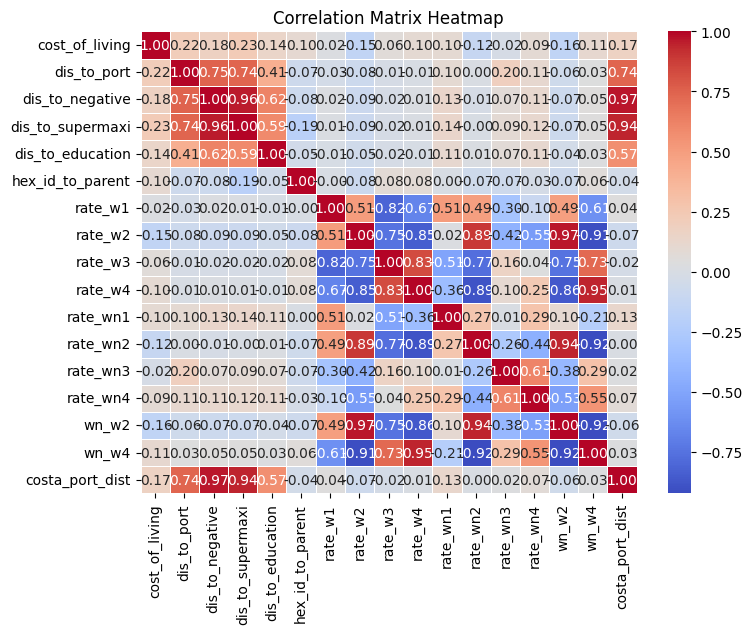

In [ ]:
df_filter_imp = df_imputed.copy()
df_filter_imp['']
valid_num_cols = ['cost_of_living', 'dis_to_port', 'dis_to_negative','dis_to_supermaxi', 'dis_to_education', 
                  'hex_id_to_parent','rate_w1', 'rate_w2', 'rate_w3', 'rate_w4', 'rate_wn1',
                  'rate_wn2', 'rate_wn3', 'rate_wn4', 'wn_w2', 'wn_w4', 'costa_port_dist']


df_filter_imp = df_filter_imp[valid_num_cols]

# ----------------------------------------Heatmap----------------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(df_filter_imp.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Matrix Heatmap")
plt.show()

# Model Training

## RandomForest Regressor

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score


df_rf = df_imputed.copy()
# df_rf['cost_of_living_log'] = df_rf['cost_of_living'].apply(lambda x: np.log(x))

x_cols = ['negative','dis_to_negative', 
    'dis_to_port', 'dis_to_supermaxi', #'dis_transport', 
    'dis_to_education', 'costa', 'missing', #'dis_car_shop',
    'wn_w4',
]

X = df_rf[x_cols]
y = df_rf['cost_of_living']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_rf = RandomForestRegressor(n_estimators=300)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)

# Calcular el Error Cuadrático Medio
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calcular el R²
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Squared Error: 0.07952057620341088
# R² Score: 0.5269227293933183
# Root Mean Squared Error (RMSE): 0.28199392937333045

# Mean Squared Error: 0.0176478868069624
# R² Score: 0.5458794697530139
# Root Mean Squared Error (RMSE): 0.13284534921088656

Mean Squared Error: 0.01752921415657378
R² Score: 0.5489331887342028
Root Mean Squared Error (RMSE): 0.13239793864170915


### Save model

In [ ]:
import pickle

# Guardar el modelo
with open('ml_models/modelo_rf.pkl', 'wb') as file:
    pickle.dump(model_rf, file)

# # Cargar el modelo
# with open('modelo.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)
# Verificar que funciona
# y_pred = loaded_model.predict(X_test)

# Model Evaluation

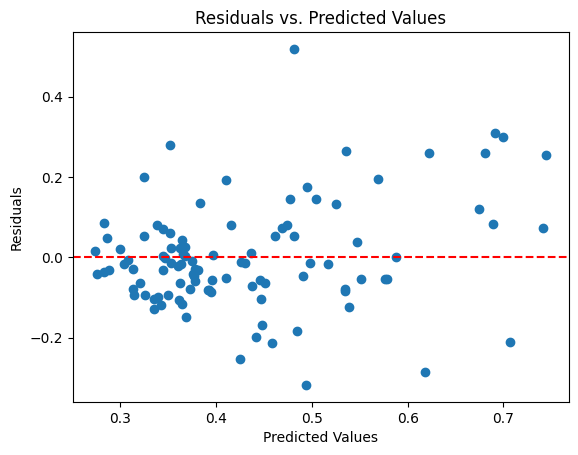

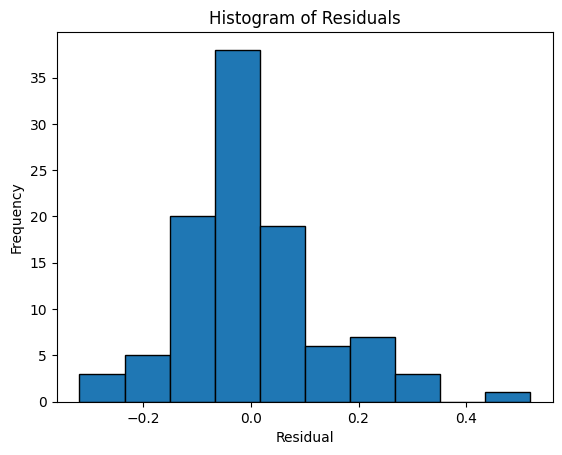

In [241]:
residuals = y_test - y_pred

# Plot residuals vs. predicted values
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Model testing

### Data Preprocessing

In [ ]:
df_test_points = raw_test.merge(df_points, how='left', on='hex_id')

__geo_tools = GeoSpatialTools()
# df_test_points['dis_to_capital'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=capital_coor_list))
df_test_points['dis_to_port'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=port_coor_list))
df_test_points['dis_to_negative'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=negative_points))
df_test_points['dis_to_supermaxi'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=supermaxi_points))
# df_test_points['dis_car_shop'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=car_points))
df_test_points['dis_to_education'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=education_points))
# df_test_points['dis_security'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=security_points))


In [ ]:
costa = ['838f0dfffffffff','838f28fffffffff','838f2afffffffff', '838f2bfffffffff', '838f2cfffffffff','838f2efffffffff']
sierra = ['8366d1fffffffff', '8366d3fffffffff', '838f29fffffffff','838f2dfffffffff', '838f72fffffffff','838f76fffffffff']
oriente = ['8366dafffffffff']

df_test_points['h_3'] = df_test_points['hex_id'].apply( lambda x: h3.cell_to_parent(x, res=3))
df_test_points['costa'] = np.where(df_test_points['h_3'].isin(costa), 1, 0)


In [268]:
valid_base_cols = ['hex_id','total_hours','work_h1','work_h2','work_h3','work_h4','wn_h1','wn_h2','wn_h3','wn_h4']
valid_points_cols = ['hex_id','cost_of_living', 'dis_to_port','dis_to_negative', 'dis_to_supermaxi', 'dis_to_education', 'costa']

base_test = df_test_points[valid_points_cols].merge(base[valid_base_cols], how='left', on='hex_id')
test_raw_features = base_test[['hex_id','cost_of_living','total_hours', 'work_h1',
                    'work_h2', 'work_h3', 'work_h4', 'wn_h1', 'wn_h2', 'wn_h3', 'wn_h4',
                    'dis_to_port','dis_to_negative', 'dis_to_supermaxi', 'dis_to_education', 'costa']].copy()
test_raw_features['missing'] = test_raw_features['total_hours'].apply(lambda x: 1 if pd.isna(x) else 0)
test_raw_features['hex_parent'] = test_raw_features['hex_id'].apply( lambda x: h3.cell_to_parent(x, res=3))
test_raw_features['hex_id_to_parent'] = test_raw_features.apply(lambda row: __geo_tools.calculate_h3_distance(row=row,
                                                                                                    hex_1='hex_id',
                                                                                                    hex_2='hex_parent'),
                                                                                                    axis=1)
test_raw_features.describe()


,cost_of_living,total_hours,work_h1,work_h2,work_h3,work_h4,wn_h1,wn_h2,wn_h3,wn_h4,dis_to_port,dis_to_negative,dis_to_supermaxi,dis_to_education,costa,missing,hex_id_to_parent
count,0.0,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,NaN,20651.294944,3761.862360,3100.250000,3942.160112,3994.426966,1523.825843,1231.373596,1532.233146,1565.162921,19.372818,10.459667,9.689237,4.165969,0.438356,0.303327,45.865161
std,NaN,13317.376288,2454.919444,2219.209555,2471.825937,2491.677923,978.466154,881.722733,963.792231,983.716441,24.733264,19.888007,20.869757,7.996481,0.496672,0.460146,11.733740
min,NaN,70.000000,12.000000,2.000000,10.000000,16.000000,11.000000,1.000000,4.000000,6.000000,0.460000,0.090000,0.100000,0.060000,0.000000,0.000000,16.827932
25%,NaN,6290.500000,1063.250000,785.250000,1344.750000,1372.500000,452.750000,308.000000,504.250000,501.750000,6.745000,2.055000,1.720000,1.140000,0.000000,0.000000,37.976480
50%,NaN,26754.500000,4933.500000,3543.500000,5119.500000,5265.500000,2015.000000,1405.500000,1975.500000,2079.000000,12.200000,3.790000,2.950000,2.050000,0.000000,0.000000,47.032885
75%,NaN,33272.000000,6113.500000,5300.000000,6348.250000,6406.500000,2447.250000,2101.750000,2449.500000,2503.000000,20.360000,8.485000,4.565000,4.125000,1.000000,1.000000,54.191956
max,NaN,36994.000000,6634.000000,6550.000000,6653.000000,6654.000000,2646.000000,2602.000000,2642.000000,2650.000000,152.890000,104.080000,106.810000,65.010000,1.000000,1.000000,75.515604


In [286]:
test_raw_features.loc[test_raw_features['hex_parent'] == '8366dafffffffff'] #8366dafffffffff

,hex_id,cost_of_living,total_hours,work_h1,work_h2,work_h3,work_h4,wn_h1,wn_h2,wn_h3,wn_h4,dis_to_port,dis_to_negative,dis_to_supermaxi,dis_to_education,costa,missing,hex_parent,hex_id_to_parent
266,8866dac555fffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.89,70.51,73.66,0.46,0,1,8366dafffffffff,34.748208


### Handdling missing values

In [288]:
test_raw_features_2 = test_raw_features[~(test_raw_features['hex_parent'] == '8366dafffffffff')].copy()
test_raw_features_2.shape

(510, 19)

In [292]:

columns_to_impute = ['total_hours', 'work_h1','work_h2', 'work_h3',
                     'work_h4', 'wn_h1', 'wn_h2', 'wn_h3', 'wn_h4']
complete_columns = ['hex_id_to_parent']  # Columnas completas

# Imputación por cluster
test_imputed_data = []

for cluster_id, group in test_raw_features_2.groupby('hex_parent'):
    test_imputer = KNNImputer(n_neighbors=5)
    test_features = group[complete_columns + columns_to_impute]
    test_imputed_values = test_imputer.fit_transform(test_features)
    group[complete_columns + columns_to_impute] = test_imputed_values
    test_imputed_data.append(group)

# Reconstruimos el DataFrame final con todos los clusters
test_df_imputed_0 = pd.concat(test_imputed_data).sort_index()

test_df_imputed_0

,hex_id,cost_of_living,total_hours,work_h1,work_h2,work_h3,work_h4,wn_h1,wn_h2,wn_h3,wn_h4,dis_to_port,dis_to_negative,dis_to_supermaxi,dis_to_education,costa,missing,hex_parent,hex_id_to_parent
0,888f2b983dfffff,NaN,31509.0,5730.0,3579.0,6603.0,6618.0,2430.0,1563.0,2445.0,2541.0,3.17,1.53,1.39,0.47,1,0,838f2bfffffffff,53.017733
1,888f2864b7fffff,NaN,2373.0,434.0,217.0,469.0,548.0,181.0,80.0,199.0,245.0,9.46,11.71,2.56,7.50,1,0,838f28fffffffff,63.616893
2,8866d33813fffff,NaN,30806.0,5523.0,4541.0,6015.0,6037.0,2237.0,1753.0,2322.0,2378.0,18.42,0.56,2.81,0.20,0,0,8366d3fffffffff,34.810855
3,888f0d9acdfffff,NaN,30396.0,5648.0,4114.0,5919.0,6029.0,2332.0,1692.0,2257.0,2405.0,3.07,1.59,1.85,3.40,1,0,838f0dfffffffff,60.138820
4,8866d33a03fffff,NaN,35383.0,6473.0,5662.0,6574.0,6601.0,2584.0,2267.0,2601.0,2621.0,16.53,1.84,1.34,1.82,0,0,8366d3fffffffff,28.621878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,888f2cb551fffff,NaN,26864.0,4912.0,2805.0,5803.0,6015.0,2043.0,1116.0,1963.0,2207.0,90.84,59.89,69.25,0.47,1,0,838f2cfffffffff,61.864924
507,888f2864e5fffff,NaN,5416.8,884.2,625.0,1239.8,1261.8,362.0,224.0,401.2,418.8,13.74,15.09,4.29,8.56,1,1,838f28fffffffff,58.812406
508,888f7699c7fffff,NaN,34352.0,6266.0,5597.0,6353.0,6464.0,2526.0,2161.0,2479.0,2506.0,0.46,0.39,0.87,1.19,0,0,838f76fffffffff,50.196650
509,8866d33137fffff,NaN,23291.0,4460.0,3519.0,4349.0,4357.0,1757.0,1348.0,1839.0,1662.0,10.85,1.87,3.06,1.46,0,0,8366d3fffffffff,33.802115


In [293]:
nul_hex_3 = test_raw_features[(test_raw_features['hex_parent'] == '8366dafffffffff')]
test_df_imputed_0 = pd.concat([test_df_imputed_0, nul_hex_3])
test_df_imputed_0.shape

(511, 19)

In [294]:
test_imputed_data = []

for cluster_id, group in test_df_imputed_0.groupby('costa'):
    test_imputer = KNNImputer(n_neighbors=5)
    test_features = group[complete_columns + columns_to_impute]
    test_imputed_values = test_imputer.fit_transform(test_features)
    group[complete_columns + columns_to_impute] = test_imputed_values
    test_imputed_data.append(group)

# Reconstruimos el DataFrame final con todos los clusters
test_df_imputed = pd.concat(test_imputed_data).sort_index()

test_df_imputed

,hex_id,cost_of_living,total_hours,work_h1,work_h2,work_h3,work_h4,wn_h1,wn_h2,wn_h3,wn_h4,dis_to_port,dis_to_negative,dis_to_supermaxi,dis_to_education,costa,missing,hex_parent,hex_id_to_parent
0,888f2b983dfffff,NaN,31509.0,5730.0,3579.0,6603.0,6618.0,2430.0,1563.0,2445.0,2541.0,3.17,1.53,1.39,0.47,1,0,838f2bfffffffff,53.017733
1,888f2864b7fffff,NaN,2373.0,434.0,217.0,469.0,548.0,181.0,80.0,199.0,245.0,9.46,11.71,2.56,7.50,1,0,838f28fffffffff,63.616893
2,8866d33813fffff,NaN,30806.0,5523.0,4541.0,6015.0,6037.0,2237.0,1753.0,2322.0,2378.0,18.42,0.56,2.81,0.20,0,0,8366d3fffffffff,34.810855
3,888f0d9acdfffff,NaN,30396.0,5648.0,4114.0,5919.0,6029.0,2332.0,1692.0,2257.0,2405.0,3.07,1.59,1.85,3.40,1,0,838f0dfffffffff,60.138820
4,8866d33a03fffff,NaN,35383.0,6473.0,5662.0,6574.0,6601.0,2584.0,2267.0,2601.0,2621.0,16.53,1.84,1.34,1.82,0,0,8366d3fffffffff,28.621878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,888f2cb551fffff,NaN,26864.0,4912.0,2805.0,5803.0,6015.0,2043.0,1116.0,1963.0,2207.0,90.84,59.89,69.25,0.47,1,0,838f2cfffffffff,61.864924
507,888f2864e5fffff,NaN,5416.8,884.2,625.0,1239.8,1261.8,362.0,224.0,401.2,418.8,13.74,15.09,4.29,8.56,1,1,838f28fffffffff,58.812406
508,888f7699c7fffff,NaN,34352.0,6266.0,5597.0,6353.0,6464.0,2526.0,2161.0,2479.0,2506.0,0.46,0.39,0.87,1.19,0,0,838f76fffffffff,50.196650
509,8866d33137fffff,NaN,23291.0,4460.0,3519.0,4349.0,4357.0,1757.0,1348.0,1839.0,1662.0,10.85,1.87,3.06,1.46,0,0,8366d3fffffffff,33.802115


In [295]:
test_df_imputed[(test_df_imputed['hex_parent'] == '8366dafffffffff')]

,hex_id,cost_of_living,total_hours,work_h1,work_h2,work_h3,work_h4,wn_h1,wn_h2,wn_h3,wn_h4,dis_to_port,dis_to_negative,dis_to_supermaxi,dis_to_education,costa,missing,hex_parent,hex_id_to_parent
266,8866dac555fffff,NaN,24738.88,4437.32,3805.44,4758.92,4772.08,1787.04,1483.12,1836.72,1858.24,152.89,70.51,73.66,0.46,0,1,8366dafffffffff,34.748208


In [298]:
test_df_imputed['total_hours'] = np.where(test_df_imputed['missing'] == 1, 
                                          test_df_imputed['work_h1'] + test_df_imputed['wn_h1'] + 
                                          test_df_imputed['work_h2'] + test_df_imputed['wn_h2'] + 
                                          test_df_imputed['work_h3'] + test_df_imputed['wn_h3'] + 
                                          test_df_imputed['work_h4'] + test_df_imputed['wn_h4'], 
                                          test_df_imputed['total_hours'])

test_df_imputed['rate_w1'] = test_df_imputed['work_h1'] / test_df_imputed['total_hours']
test_df_imputed['rate_w2'] = test_df_imputed['work_h2'] / test_df_imputed['total_hours']
test_df_imputed['rate_w3'] = test_df_imputed['work_h3'] / test_df_imputed['total_hours']
test_df_imputed['rate_w4'] = test_df_imputed['work_h4'] / test_df_imputed['total_hours']
test_df_imputed['rate_wn1'] = test_df_imputed['wn_h1'] / test_df_imputed['total_hours']
test_df_imputed['rate_wn2'] = test_df_imputed['wn_h2'] / test_df_imputed['total_hours']
test_df_imputed['rate_wn3'] = test_df_imputed['wn_h3'] / test_df_imputed['total_hours']
test_df_imputed['rate_wn4'] = test_df_imputed['wn_h4'] / test_df_imputed['total_hours']

test_df_imputed['wn_w2'] = test_df_imputed['rate_w2'] * test_df_imputed['rate_wn2']
test_df_imputed['wn_w4'] = test_df_imputed['rate_w4'] + test_df_imputed['rate_wn4']


In [299]:
x_cols = [
    'dis_to_port', 'dis_to_negative', 'dis_to_supermaxi', 
    'dis_to_education', 'costa', 'missing', 'wn_w4', 
]

y_pred_test = model_rf.predict(test_df_imputed[x_cols])


In [300]:
len(y_pred_test)

511

In [302]:
output = raw_test.copy()
# exp_y_pred = np.exp(y_pred_test)
output['cost_of_living'] = y_pred_test

In [303]:
output.head()

,hex_id,cost_of_living
0,888f2b983dfffff,0.519949
1,888f2864b7fffff,0.389133
2,8866d33813fffff,0.412717
3,888f0d9acdfffff,0.724682
4,8866d33a03fffff,0.387672


In [304]:
output.to_csv('model_results/output_v2.csv', index=False)